***
# Sentiment Analysis

With the rise of online social media platforms like Twitter, Facebook and Reddit, and the proliferation of customer reviews on sites like Amazon and Yelp, we now have access, more than ever before, to massive text-based data sets! They can be analyzed in order to determine how large portions of the population feel about certain products, events, etc. This sort of analysis is called sentiment analysis. In this notebook you will build an end-to-end sentiment classification system from scratch.

***

What will be doing in the notebook
* Exploring the dataset ( here we will be using the <a href="https://ai.stanford.edu/~amaas/data/sentiment/" tagret="_blank" > IMDb dataset </a> )
    * It consists of movie reviews from <a href="https://imdb.com" target="_blank"> imdb.com </a> where each comment is labeled as either 'positive', if the reviewer enjoyed the movie or 'negative', otherwise.
    * It can be found in the 'data' subdirectory of this folder

<br>

* Preprocessing this given data according to our needs
    * Since it contains unnecessary HTML tags, stop words, non-letter characters

<br>

* Extracting the Bag of Words (BoG) features from the preprocessed data ( using CounterVectorizer from <a href="https://scikit-learn.org/stable/"> scikit learn library</a>)

<br>

* Classifying the comments using the Bag of Words feature implemented above ( mainly by using the Naive Bayes Classifier ( as done in the spam classifier project ))

<br>

* Since Bag of Words feature is a very basic approach that can be fooled easily, we will then be using Recurrent Neural Networks to improve our sentimental analyser


***



In [2]:
! pip3 install wordcloud
! pip3 install sklearn

! pip3 install nltk
nltk.download('stopwords')


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


NameError: name 'nltk' is not defined

## Exploring the dataset

In [ ]:
from cProfile import label
import os
import glob  # helps in returning all file paths that match a specific pattern


def read_imdb_data(data_dir='data/imdb-reviews'):
    """
    Functions to the read IMDB movie reviews from the given directory and return them along with their respective labes

    'data' directory structure explained
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    """

    # the structure will be
    # {'train' : {'pos' : [list of positive reviews], 'neg' : [list of negative reviews]}, 'test' : {'pos' : [list of positive reviews], 'neg' : [list of negative reviews]}}
    data = {}  # to store the reviews
    labels = {}  # to store the respective label of the reviews (pos or neg)

    # will recurse in the train and test subdirecotries in the data folder
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # further to recurse in the subdirectories of train and test
        for sentiment in ['pos', 'neg']:
            # list to store all the reviews
            data[data_type][sentiment] = []

            # lis to store the respective tags to all those reviews
            labels[data_type][sentiment] = []

            # fetching the list of all the files for that data type and sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            # returns the list of paths matching the pathname ( for example here the path name is data/imdb-reviews/train/pos/0_9.txt)
            files = glob.glob(path)

            # now since files is a list to all the pathnames of the files in the folder, we will recurse through all the files and store their data in data and their respective labels in labels
            for f in files:
                with open(f) as review: 
                    data[data_type][sentiment]. append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                "{}/{} data size does not match labels size".format(data_type, sentiment)

    return data, labels


In [ ]:
# since we have mentioned th edefault direcotry path in the definition of the function itself, we do not need to write it again, unless we want to provide a different directory name
data, labels = read_imdb_data()

print("IMDB reviews : train = {} pos / {} neg, test = {} pos / {} neg". format(len(data['train']['pos']), len(data['train']['neg']),
                                                                               len(data['test']['pos']), len(data['test']['neg'])))


print("\n\n--- HERE IS A POSITIVE TRAINING DATA SET REVIEW ----\n", data['train']['pos'][2])
print("\n\n--- HERE IS A NEGATIVE TRAINING DATA SET REVIEW ----\n",data['train']['neg'][2])


IMDB reviews : train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


--- HERE IS A POSITIVE TRAINING DATA SET REVIEW ----
 While this movie has many flaws, it is in fact a fun '80s movie. Eddie Murphy peaks during his 80's movies here. While his character is indistinguishable from earlier movies, his timing is almost flawless with perfect partners and foils.<br /><br />Couple this with the hypnotic beauty of Charlotte Lewis, this makes for a fun rainy day action-comedy flick.<br /><br />


--- HERE IS A NEGATIVE TRAINING DATA SET REVIEW ----
 My wife and I both agree that this is one of the worst movies ever made. Certainly in the top ten of those I've watched all the way through. At least "Plan 9" was enjoyable.<br /><br />I DID really enjoy "Christine", "The Dead Zone", "Firestarter", "Carrie", and some of his other films. I didn't care much for "Cujo" (only because the sound was so bad on versions I've seen and I often couldn't tell what people were saying), or "Pet Sematary

### Wordcloud visualization of words in the positive and negative training sets

 >  pos  reviews wordcloud:


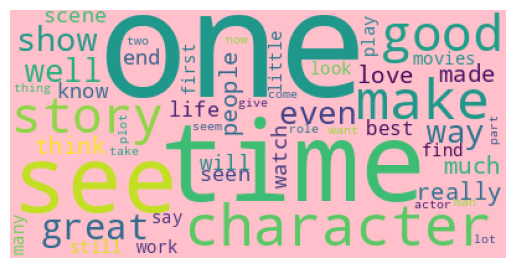

 >  neg  reviews wordcloud:


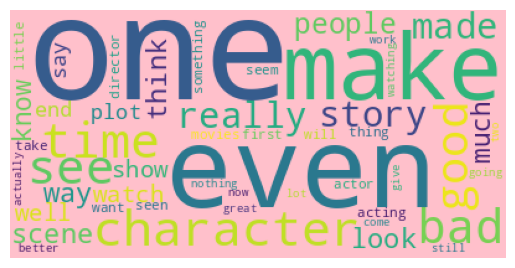

In [ ]:

from ossaudiodev import SOUND_MIXER_LINE1
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sent =['pos','neg']

for sentiment in sent:
    combined_text=" ".join([review for review in data ['train'][sentiment]])
    # updating STOPWORDS with words like movie and film so that they do not show up in the wordcloud along with other stopwords
    wc = WordCloud(background_color='pink', max_words=50, stopwords=STOPWORDS.update(['br', 'movie', 'film','films']))

    plt.imshow(wc.generate(combined_text))
    plt.axis('off')
    print(" > ", sentiment, " reviews wordcloud:")
    plt.show()


***
### Combining the negative and positive documents to get one unified training and testing set for further use

***

In [ ]:
from sklearn.utils import shuffle
import random
from pprint import pprint

def prepare_imdb_data(data):
    """
    Preparing the training and testing sets from the files
    """
    data_train=[]
    data_test=[]
    labels_train=[]
    labels_test=[]
    train_tuple=[]
    test_tuple=[]
    # Combining the negative and positive labeled data into one unified data
    for sentiment in data['train']:
        for review in data['train'][sentiment]:
            train_tuple.append((review, sentiment))
    
    for sentiment in data['test']:
        for review in data['test'][sentiment]:
            test_tuple.append((review, sentiment))


    train_tuple = shuffle(train_tuple, random_state=1)            
    test_tuple = shuffle(test_tuple, random_state=1)            
    for item in train_tuple:
        data_train.append(item[0])
        labels_train.append(item[1])

    for item in test_tuple:
        data_test.append(item[0])
        labels_test.append(item[1])

    return data_train, data_test, labels_train, labels_test

In [ ]:
data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

for i in range(len(data_train)):
    if i >5 :
        break
    print(labels_train[i])

IMDb reviews (combined): train = 25000, test = 25000
neg
pos
neg
neg
pos
pos


***
## Preprocessing(/cleaning) the data 

Our raw data includes HTML. Therefore there are HTML tags that need to be removed. We also need to remove non-letter characters, normalize uppercase letters by converting them to lowercase, tokenize, remove stop words, and stem the remaining words in each document.

***

In [ ]:
from html.entities import html5
from tracemalloc import stop
from bs4 import BeautifulSoup # to help in rremoving the HTML tags
import re # for helping in removing the non-letter characters
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()

stopwords_list = stopwords.words('english')

def review_to_words(review):
    """
    Converting the raw review strings to a sequence of clean words
    """
    # removing the html tags
    soup=BeautifulSoup(review,'html5')
    clean = soup.get_text()

    #converting the string to a list
    clean_list=clean.split()

    # to remove the non-letter words
    for i in range(len(clean_list)):
        clean_list[i] = re.sub('[^a-zA-Z ]','', clean_list[i])

    #removing the stopwords
    clean_list = [i for i in clean_list if i not in stopwords_list]

    # stemming the words in the corpus
    clean=[stemmer.stem(i) for i in clean_list]

    return clean

# print(review_to_words("""This is just a <em>test</em>.<br/><br /> But if it wasn't a test, it would make for a <b>Great</b> movie review!"""))





### Creating a cache file to store the cleaned reviews temporarily
With the function review_to_words() fully implemeneted, we can apply it to all reviews in both training and test datasets. This may take a while, so let's build in a mechanism to write to a cache file and retrieve from it later.

In [ ]:
import pickle

# this folder will store the cache files
cache_dir = os.path.join("cache", "sentiment_analysis")
os.makedirs(cache_dir, exist_ok=True)  # ensure that the directory exists


# pickle files have the extension ".pkl"
def preprocess_data(data_train, data_test, labels_train, labels_test, cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """
    Convert each review to words
    Read from cache if available
    """

    # checks if the cache file is empty, if not then read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)

            print(
                " Reading preprocessed data from the pre-existing cache file:", cache_file)
        except:
            pass  # if not able to read cache still it is fine.

    # if there is no previous cache file, then do heavy-lifting
    if cache_data is None:

        # preprocess the training and testing data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))

        # Write to the cached file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)

            with open(os.path.join(cache_dir, cache_file), "wb")as f:
                pickle.dump(cache_data, f)
                print(
                    " >  Done writing preprocessed data to the cache file : ", cache_file)

    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (
            cache_data['words_train'], cache_data['words_test'], cache_data['labels_test'], cache_data['labels_test'])

    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)


# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

/usr/lib/python3/dist-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


 >  Done writing preprocessed data to the cache file :  preprocessed_data.pkl

--- Raw review ---
A common plotline in films consists of the main characters leaving the hustle and bustle of the city behind, and finding themselves in the tranquility of nature. In Power of Kangwon Province, we are shown two stories of individuals doing just that, trying to find themselves through a trip to the popular Korean parks in the mountains of Kangwon Province. However, rather than epiphanal moments, we have two characters whose trip into nature was just another form of escape.<br /><br />The pace of this movie is slow, contemplative. We learn in the end what really brought each to Kangwon Province and we learn how they're connected. For those who want Hollywood glam and for a movie to give them a definitive answer, this movie will not satisfy. But for those who want a movie that leaves them thinking, wondering, affecting them years after, this movie will more than satiate that longing.

--- Prepr